# C. Help Each Other from Now on

## 어이 없는 실수 없애기

Appendix B에서 얻은 model이 지는 경우는 다음과 같습니다.

```
 [ Turn  19 ; 2P's turn (tone = X) ]
  | 0 1 2 3 4 5 6 7 8 9 A B C D E
--+------------------------------
0 | . . . . . . . . . . . . . . .
1 | . . . . . . . . . . . . . . .
2 | . . . . . . . . . . . . . . .
3 | . . . . . . . . . . . . . . .
4 | . . . . . . . . . . . . . . .
5 | . . . . . . . . . . . . . . .
6 | . . . . . O O O O O X . . . .
7 | . . . . . . O . X . X . . . .
8 | . . . . . . O X X X X O . . .
9 | . . . . . . . . X . X . . . .
A | . . . . . . . O . O . . . . .
B | . . . . . . . . . . . . . . .
C | . . . . . . . . . . . . . . .
D | . . . . . . . . . . . . . . .
E | . . . . . . . . . . . . . . .
1p (agent-df) win!
```
Last 5 moves
```
... -> A7 -> 9A -> 67 -> 6A -> 66
```

위에서 후공(X)의 6A는 사람 눈에는 실수로 보일 수 밖에 없습니다.
만약 66을 막았으면 방어가 될 것이고, 그 다음에 6A나 6B 등으로
공격해나가도 된다는 것이죠.

이런 문제가 생기는 가장 큰 문제는 현재까지 오목 학습에서는
이긴 사람의 수를 따라하려고 하다보니, 열심히 방어를 하다 지는
경우, 즉, '졌지만 잘 싸웠다' 같은 상황은 아예 버려버리게 됩니다.
따라서 방어하는 수를 제대로 배울 기회가 없다는 것입니다.

그러면 알고리즘이 못 두는 수를 두려고 강화학습을 했는데,
강화학습이 잘 못하는 부분은 무엇으로 보완해야 할까요?

## 끝내는 수 강제하기

오목에서는 사실상 나오면 끝나는 수가 몇개 있습니다.
자신의 차례 기준으로

- 자신의 돌로 4목: 열린쪽에 두면 끝 (0수 종료)
- 상대의 돌로 4목: 열린쪽을 모두 막지 않으면 다음 차례의 상대가 두어서 끝 (1수 종료)
- 자신의 돌로 열린 3목: 자신이 열린 4목이 되도록 둔다면 그 다음
자신의 차례에 끝 (2수 종료)
- 상대의 돌로 열린 3목: 자신이 한쪽을 막지 않으면, 상대의 2수로
상대 차례에 끝 (3수 종료)

라고 나눌 수 있습니다.
이 때 괄호 안의 수를 바탕으로 속도를 계산해야 됩니다.
예를 들어서 자신의 열린 3목이 있더라도 상대 4목이 있다면
상대의 공격이 더 빠르므로 그쪽에 먼저 대응을 해야하는 것이죠.

그럼 저것을 어떻게 학습시켜야 하는가 물어볼 수 있는데,
여기서는 *학습시키지 않습니다*.
방어하는 수를 학습시키는 것은 귀찮고 오래 걸릴 수 있으니
번거로운 수보다는 이미 있는 방법을 쓰는 것이 나을 것입니다.

그래서 여기서는 `Analysis`를 이용해서 agent의 동작을 강제합니다.

우선은 아래와 같이 학습 모듈은 제외하고, 실행에 필요한 모듈을
모두 준비합니다.

### Environment

In [1]:
!rm -rf mock5.py mock5 gen.cpp read_record.py gen
!git clone https://github.com/lumiknit/mock5.py
!mv mock5.py/mock5 .
!mv mock5.py/gen2_record/gen.cpp .
!mv mock5.py/gen2_record/read_record.py .
!g++ -O2 -fopenmp -o gen gen.cpp

Cloning into 'mock5.py'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 152 (delta 74), reused 121 (delta 47), pack-reused 0
Receiving objects: 100% (152/152), 40.10 KiB | 13.37 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [9]:
from mock5 import Mock5
from mock5.analysis import Analysis as M5Analysis
import mock5.analysis as m5analysis
import mock5.agent_random as m5rand
import mock5.agent_analysis_based as m5aa
import mock5.agent_ad as m5ad
import mock5.agent_pt as m5pt
import mock5.agent_df as m5df

import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import os
import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: {}".format(device))

torch.backends.cudnn.benchmark = True
torch.autograd.set_detect_anomaly(False)

print("cudnn: {} (det {}; bench {})".format(
    torch.backends.cudnn.enabled,
    torch.backends.cudnn.deterministic,
    torch.backends.cudnn.benchmark))
print("OpenMP: {}".format(torch.backends.openmp.is_available()))

Device: cuda
cudnn: True (det False; bench True)
OpenMP: True


### Board Size

In [3]:
H, W = 15, 15

### Agent & Policy Transformer

In [4]:
def fn_name(fn):
  if hasattr(fn, 'name'): return fn.name
  else: return repr(fn)
  
def agent(pi, epsilon=0):
  # pi must return array of non-negative values
  def c(game):
    w, h = game.width, game.height
    m, p = np.ones(h * w), np.array(pi(game))
    for i in range(h * w):
      if game.board[i] != 0: m[i], p[i] = 0, 0
    s = p.sum()
    if np.random.uniform() < epsilon or s == 0:
      s = m.sum()
      if s == 0: return None, None # Cannot do anything
      else: idx = np.random.choice(h * w, p=(m / s))
    else: idx = np.random.choice(h * w, p=(p / s))
    return idx // w, idx % w
  c.name = 'stochastic({})'.format(fn_name(pi))
  return c

def agent_mixed(game):
  a = np.random.uniform()
  if a < 0.4: return m5aa.agent(game)
  elif a < 0.8: return m5ad.agent(game)
  elif a < 0.9: return m5pt.agent(game)
  else: return m5df.agent(game)
agent_mixed.name = 'agent-mixed-analysis-based'

In [5]:
def test_agents(num_game, agent1, agent2, p_msg=True):
  w1, w2 = 0, 0
  c1, c2 = 0, 0
  for i in range(num_game):
    g = Mock5(H, W)
    if i % 2 == 0:
      result = g.play(agent1, agent2, random_first=False,
        print_intermediate_state=False, print_messages=False)
    else:
      result = g.play(agent2, agent1, random_first=False,
        print_intermediate_state=False, print_messages=False)
      if result != 0: result = 3 - result
    if result == 1:
      w1 += 1
      c1 += len(g.history)
    elif result == 2:
      w2 += 1
      c2 += len(g.history)
  if p_msg:
    print("-- Test Result --")
    print("* Agent1 = {} \n* Agent2 = {}".format(
        fn_name(agent1), fn_name(agent2)))
    print("Total : {:5d}".format(num_game))
    print("A1 Win: {:5d} ({:5.3f}) (avg.mov {:6.1f})".format(w1, w1 / num_game, c1 / max(1, w1)))
    print("A2 Win: {:5d} ({:5.3f}) (avg.mov {:6.1f})".format(w2, w2 / num_game, c2 / max(1, w2)))
  return (w1 + (num_game - w1 - w2) * 0.5) / num_game

### Neural Network


In [6]:
class Flatten(nn.Module):
  def forward(self, x):
    if len(x.shape) == 3: return x.view(-1)
    else: return x.flatten(1, -1)

class Block1(nn.Module):
  def __init__(self, ch, int_ch, ker):
    super().__init__()
    self.seq = nn.Sequential(
      nn.Conv2d(ch, int_ch, ker, padding='same'),
      nn.GELU(),
      nn.Conv2d(int_ch, ch, ker, padding='same'))
  def forward(self, x):
    y_0 = self.seq(x)
    return nn.functional.gelu(x + y_0)

class Policy(nn.Module):
  def __init__(self):
    super().__init__()
    self.seq = nn.Sequential(
      nn.Conv2d(2, 128, 3, padding='same'),
      nn.GELU(),
      Block1(128, 128, 3),
      Block1(128, 128, 3),
      Block1(128, 128, 3),
      nn.Conv2d(128, 1, 5, padding='same'),
      nn.GELU(),
      # Flatten
      Flatten(),
      # Softmax
      nn.LogSoftmax(dim=-1))

  def forward(self, x):
    return self.seq(x)

def game_to_tensor(game):
  t = torch.zeros(2, game.height * game.width, dtype=torch.float)
  for i in range(game.height * game.width):
    b = game.board[i]
    if b == game.player: t[0][i] = 1.0
    elif b != 0: t[1][i] = 1.0
  return t.view(2, game.height, game.width)

def policy_model(net):
  def c(game):
    X = game_to_tensor(game).to(device)
    with torch.no_grad():
      p = torch.exp(net(X))
    arr = p.squeeze().to('cpu').numpy()
    return arr
  c.name = 'model({:x})'.format(id(net))
  return c

def agent_policy(net):
  return agent(policy_model(net))

In [14]:
NUM_SLOTS_HOF = 5
WEIGHT_FILE = 'app_b_last.weight'
WEIGHT_FILE_IDX = lambda idx: "app_b_{:08x}.weight".format(idx)

def load_hof_file(filename):
  global hof, pns
  hof = torch.load(WEIGHT_FILE)
  pns = [None] * NUM_SLOTS_HOF
  for i in range(NUM_SLOTS_HOF):
    pns[i] = Policy().to(device)
    pns[i].load_state_dict(hof['slots'][i]['dict'])
    print("  ([{}] al score {})".format(i, hof['slots'][i]['al_score']))

def load_last_hof(): load_hof_file(WEIGHT_FILE)
def load_hof(index): load_hof_file(WEIGHT_FILE_IDX(index))

def init_curr():
  global curr, curr_pn
  curr_pn = Policy().to(device)
  curr = {
    'dict': None,
    'gen': hof['gen'],
    'al_score': 0 }
  idx = np.random.randint(NUM_SLOTS_HOF)
  curr_pn.load_state_dict(hof['slots'][idx]['dict'])

## Policy Transformer

여기서는 다시 policy transformer를 만들어서 사용할 것입니다.
이 policy가 하는 역할은 다음과 같습니다:

- `Analysis`를 바탕으로 오목판을 분석
- 만약 자신이나 상대의 4목 또는 열린 3목이 있다면 우선순위에
맞춰서 해당 수만 1, 그 외에는 0을 갖는 마스크를 생성
- 만약 그런 수가 없다면 둘 수 있는 모든 곳을 1, 그 외에는
0을 갖는 마스크를 생성
- 만약 기존 policy에 마스크를 곱해서 모두 0이 되면
마스크 자체를 반환
- 그 외에는 마스킹된 policy를 반환

여기서 마스크의 1은 그 행동에 대한
 원래 policy의 값을 유지하겠다는 것이고,
0은 그 행동을 할 확률을 0으로 만들겠다는 것입니다.
만약 마스크를 씌워서 전부 0이 된다는 것은 애초에 위험한 칸 중
어느 쪽을 고를지에 대한 우선순위가 없다는 것이고,
이 때는 그 중 랜덤으로 고르면 무방합니다.



In [51]:
def rescore(game, a, idx):
  m = max([a.get_critical_at(game.player, dir, idx) for dir in range(4)])
  o = max([a.get_critical_at(3 - game.player, dir, idx) for dir in range(4)])
  ad = 0
  if m >= o:
    ad = 1
    o = m
  if o >= m5analysis.N_5: return ad + 4
  elif o >= m5analysis.N_OPEN_4: return ad + 2
  else: return 1

def pt_regulate(policy):
  def p(game):
    p = policy(game)
    a = M5Analysis(game)
    score = np.zeros(game.height * game.width)
    for i in range(game.height * game.width):
      if game.board[i] == 0: score[i] = rescore(game, a, i)
    mmax = score.max()
    mask = (score >= mmax).astype(float)
    masked = p * mask
    if masked.sum() <= 0: return mask
    else: return masked
  p.name = 'pt_regulate({})'.format(policy.name)
  return p

def agent_model(net):
  return agent(pt_regulate(policy_model(net)))

### Algorithm과 대국

In [44]:
load_last_hof()
init_curr()

  ([0] al score 4.4399999999999995)
  ([1] al score 4.3933333333333335)
  ([2] al score 4.52)
  ([3] al score 4.533333333333333)
  ([4] al score 4.4799999999999995)


In [45]:
a = [m5aa, m5ad, m5pt, m5df]
for i in range(len(a)):
    test_agents(100, agent_model(curr_pn), a[i].agent)

-- Test Result --
* Agent1 = stochastic(pt_regulate(model(7f10ec14a990))) 
* Agent2 = agent-analysis-based
Total :   100
A1 Win:    94 (0.940) (avg.mov   20.9)
A2 Win:     4 (0.040) (avg.mov   29.0)
-- Test Result --
* Agent1 = stochastic(pt_regulate(model(7f10ec14a990))) 
* Agent2 = agent-analysis-defensive
Total :   100
A1 Win:    98 (0.980) (avg.mov   21.2)
A2 Win:     2 (0.020) (avg.mov   45.0)
-- Test Result --
* Agent1 = stochastic(pt_regulate(model(7f10ec14a990))) 
* Agent2 = agent-pt
Total :   100
A1 Win:    90 (0.900) (avg.mov   26.2)
A2 Win:    10 (0.100) (avg.mov   62.7)
-- Test Result --
* Agent1 = stochastic(pt_regulate(model(7f10ec14a990))) 
* Agent2 = agent-df
Total :   100
A1 Win:    87 (0.870) (avg.mov   26.3)
A2 Win:    13 (0.130) (avg.mov   80.1)


위 transformer를 적용하여 여러번 테스트 하면 다음과 같은
차이를 볼 수 있습니다.

- 흔히 방어를 안 해서 지는 실수가 대거 사라지기 때문에,
종료까지 걸리는 시간이 비교적 증가합니다.
- 무승부가 비교적 자주 발생하게 됩니다.
- 승률에 개선은 있지만 극적이지는 않은데,
가장 큰 이유로는 이 agent가 가장자리 싸움은 그다지 학습하지
못해서 그럴 것입니다.

승률 개선이 극적이지 않다는 것은 나름 긍정적으로 볼 수도 있는데,
위에서 추가적을 해준 것은 정확한 수 외에 게임이 한/두수 내로
끝나는 상황에서도 왠만하면 정확한 판단을 해줄 정도로
학습이 이루어졌다는 것입니다.

예를 들어서 

 [ Turn  94 ; 1P's turn (tone = O) ]
  | 0 1 2 3 4 5 6 7 8 9 A B C D E
--+------------------------------
0 | . . . . . . . . . . . . . . .
1 | . X . . O X . . . . . . . . .
2 | . O X . . . . . . . . . X . .
3 | . O O O X O O . X . O O . X .
4 | . X X O X X . X O X X X . . .
5 | . . . X X X O O O X O O X . O
6 | . . O X O O X O X O . O O X .
7 | . X O . . X O O O X O X . . .
8 | . . X . . O O X O O O O X . .
9 | . . . . X . . X O X X . X O .
A | . . . . O . . X X . O O O X .
B | . . . . . . . X . . . O X . .
C | . . . . . . . X O X X X O . .
D | . . . . . . . . X O O O . X .
E | . . . . . . . . . . . . . . .
2p (agent-df) win!


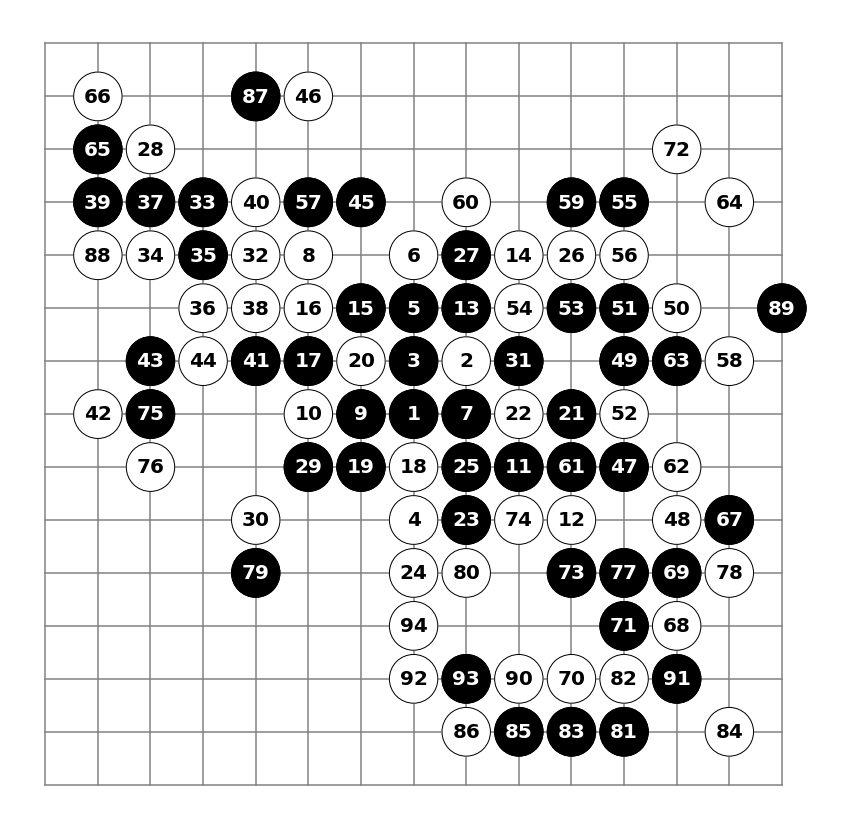

In [65]:
m = Mock5(H, W)
m.play(agent_model(curr_pn), m5df.agent,
  print_intermediate_state=False)
m.plot()
plt.show()
plt.close()

현재 `df`에게 패배하는 경우는 위처럼 게임이 질질 끌리는 경우인데
이 때 흑89 같이 판 가장자리에서 이상한 수를 두고
게임을 말아먹는 경우를 볼 수 있습니다.

In [ ]:
m = Mock5(H, W)
m.play(agent(policy_model(curr_pn)))

In [ ]:
m.plot()
plt.show()